# Ensemble Methods Overview

From Chapter 7 of Hands-On Machine Learning textbook by Aurelien Geron. 

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

### Voting Classifiers
Suppose you have a bunch of separate classifers. A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. **This majority-vote classifier is called a hard voting classifier:**

![](pictures/ensemb.jpg)

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. **In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.**


Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! **However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data.** <font color=red> One way to increase independence is to train classifiers using different algos!!! </font>

In [3]:
# Use the partial function to reduce repeating code
from functools import partial

def multiply(x,y):
    return x * y

# create a new function that multiplies by 2
dbl = partial(multiply,2)
print(dbl(8))

16


X: (1000, 2)
y: (1000,)
X_train: (750, 2)
y_train: (750,)


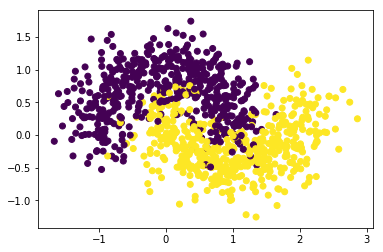

RandomForestClassifier 0.904
SVC 0.912
LogisticRegression 0.852
VotingClassifier 0.908
VotingClassifier 0.916


C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from functools import partial
from sklearn.datasets import make_moons

random_state=42
# IMPORT DATASET
X, y = make_moons(n_samples=1000, noise=0.30, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
print("X:", X.shape)
print("y:", y.shape)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# BUILD CLASSIFIERS
rnd_clf = RandomForestClassifier(random_state=random_state)
svm_clf = SVC(kernel='rbf', random_state=random_state, probability=True)
log_clf = LogisticRegression(random_state=random_state)

# STACK MODELS INTO VOTING CLASSIFIER
voting_clf_base = partial(VotingClassifier, estimators=[('RF',rnd_clf), ('SVM',svm_clf), ('LOGIT',log_clf)])
voting_clf_hard = voting_clf_base(voting='hard')
voting_clf_soft = voting_clf_base(voting='soft')

# TRAIN AND TEST ALL MODELS!
for clf in (rnd_clf, svm_clf, log_clf, voting_clf_hard, voting_clf_soft):
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, preds))
    

**WHOA! The voting classifier did better than the individual classifiers!!! AND the SOFT VOTING Classifier (which averages the probabilities of all predictions) did the best, neat!!!**

If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting.** It often achieves higher performance than hard voting because it **gives more weight to highly confident votes.** All you need to do is replace `voting="hard"` with `voting="soft"` and ensure that all classifiers can estimate class probabilities.

This is not the case of the SVC class by default, so you need to set `probability=True`; this will make the SVC class use cross-validation to estimate class probabilities (using a LogisticRegression), slowing down training, but it will add a `predict_proba()` method to the model.

### Bagging and Pasting
Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. 

- **Bagging**: When sampling is performed with replacement,this method is called bagging (short for bootstrap aggregating). 
- **Pasting**: When sampling is performed without replacement, it is called pasting.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. Scikit-learn has a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression). 

The following codes trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set **WITH replacement (sklearn uses BAGGING by default).** If you wanted to use pasting you would just seting `bootstrap=False`. 

**NOTE: Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well. The `n_jobs` paramter tells scikit learn the number of CPU cores to use for training predictions (-1 tells scikit-learn to use ALL available cores).**

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#BAGGING CLASSIFIER WITH 500 DTCs
bag_clf = BaggingClassifier(DecisionTreeClassifier(), #use DTs as base
                            n_estimators=500, # 500 trees
                            max_samples=100, # Only use 100 samples for each tree
                            bootstrap=True, # REPLACE after each sample selected
                            n_jobs=-1) # Use all CPU cores (parellel processing)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

#SINGLE DTC
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("Bagging accuracy:", accuracy_score(y_test, y_pred))
print("Single Tree:", accuracy_score(y_test, y_pred_tree))

Bagging accuracy: 0.904
Single Tree: 0.892


The BaggingClassifier **automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method)**, which is the case with Decision Trees classifiers.

The picture below compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the following code), both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: **the ensemble has a comparable bias but a smaller variance (it makes the same number of erros on the training set, but the decision boundary is less irregular)**

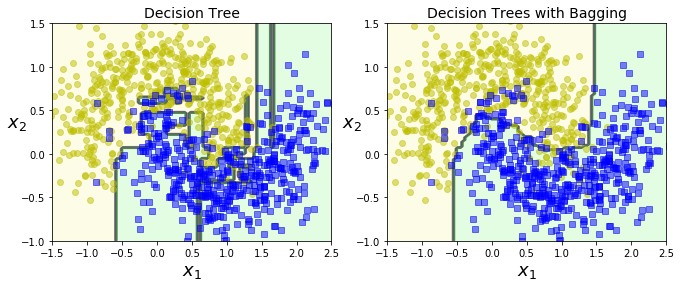

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

### Out-of-Bag Evaluation
By default a **BaggingClassifier samples m training instances WITH replacement (bootstrap=True), where m is the size of the training set.** This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.

**Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation.** 

You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor. In Scikit-Learn, you can set `oob_score=True` when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. 

The resulting evaluation score is available through the `oob_score_` variable: ***THIS IS THE AVERAGE OOB SCORE. NEAT!!!***


In [7]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_ # Get average Out-Of-Bag (oob) score

0.9026666666666666

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

**Nice! We got similar accuracy scores on the Out of Bag (OOB) and the actualy test sets. Makes sense!**

### Random Patches and Random Subspaces
The BaggingClassifier class supports **sampling the features as well**. This is controlled by twohyperparameters: 
- `max_features`
- `bootstrap_features`

They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features. This is particularly **useful when you are dealing with high-dimensional inputs (such as images)**.

- **RANDOM PATCHES:** Sampling both training instances and features is called the Random Patches method.

- **RANDOM SUB SPACES:** Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than 1.0) is called the RandomSubspaces method.

*Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.*

# Random Forests

As we have discussed, a Random Forest is an ensemble of Decision Trees, generally **trained via the bagging method (or sometimes pasting)**,
- typically with `max_samples set to the size of the training set (so each tree can sample the number of samples in the training set (though with BAGGING (with replacement) thatll result in about 67% of samples being selected).

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks)

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), **using all available CPU cores:**

## RandomForestClassifier Implementation

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#n_estimators = number of trees
#max_leaf_nodes = max number of final leaf nodes
#n_jobs = -1 tells comp to use parrallelize with all CPUs
#max_features = 'sqrt' (this is the same as 'auto' and just takes the square root of num_features)

rnd_clf = RandomForestClassifier(max_features = 'sqrt',
                                 n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1,
                                 oob_score=True)

rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(rnd_clf.oob_score_)
accuracy_score(y_test, y_pred_rf)

0.9146666666666666


0.924

**With a few exceptions a RandomForestClassifier has all the hyperparametersof a DecisionTreeClassifer (to control how the trees are grown) plus ALL the hyperparameters of a Bagging Classifier to conrol the ensemble itself.**

The random forest srearches for the best feature among a SUBSET of features. The result is tree diversity, which **trades a higher bias for a lower variance, generally yeilding a overall better and more generalizable model.** 

**NOTE: RandomForestClassifier also used soft margin voting to make predictions... So it essentially calls `predict_proba` on each individual tree, and then makes a decision based on the average probability score.**

EXTRA TREES: At each node in a random forest tree, only a random subset of the features is considered for splitting. 


## Feature Importance

Lastly, if you look at a single Decision Tree, **important decisions are likely to appear CLOSER to the root of the tree (the top), while unimportant features will often appear closer to the leaves (OR NOT AT ALL).**

**It is therefore possible to get an estimate of a feature’s importance by computing the average depth at which it appears across all trees in the forest.** Scikit-Learn computes this automatically for every feature after training. You can access the result using the **feature_importances_** variable. 

#### So the higher the feature_importances_ value, the more important the feature! below, the petal length seems to be the most important!!!

In [105]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10796720501973339
sepal width (cm) 0.023954202058917785
petal length (cm) 0.46625573332631914
petal width (cm) 0.40182285959503


**There are indeed several ways to get feature "importances". As often, there is no strict consensus about what this word means.**

In scikit-learn, we implement the "gini importance" or "mean decrease impurity", which is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

**Let's try to calculate feature importances for the MNIST dataset!**

In [106]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [107]:
# default number of estimators
len(rnd_clf.estimators_)

10

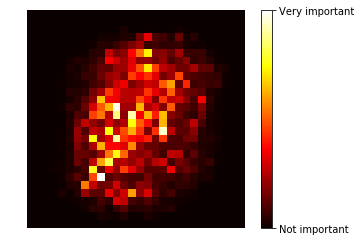

In [108]:
import matplotlib.pyplot as plt
import matplotlib

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

**Makes sense! The features in the middle of the image (where the actual print of the digit is) are the most important.**

In general, Random Forests are very handy to get a quick understanding of what features actually matter, especially if you need to perform Feature Selection.

## RandomForestClassifier Documentation
`Init signature: RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)`

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The **sub-sample size is always THE SAME SIZE AS THE ORIGINAL INPUT SAMPLE SIZE but the samples are drawn with replacement if `bootstrap=True` (default), which meanins only about 67% of samples will be selected each iteration.**

#### Parameters
`n_estimators : integer, optional (default=10)`
- The number of trees in the forest.

`criterion : string, optional (default="gini")`
- The function to measure the quality of a split. 
- Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain. 
- Note: this parameter is tree-specific.

`max_features : int, float, string or None, optional (default="auto")`
- The number of features to consider when looking for the best split:
    - If int, then consider `max_features` features at each split.
    - If float, then `max_features` is a percentage and `int(max_features * n_features)` features are considered at each
      split.
    - If "auto", then `max_features=sqrt(n_features)`.
    - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
    - If "log2", then `max_features=log2(n_features)`.
    - If None, then `max_features=n_features`.

    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.

`max_depth : integer or None, optional (default=None)`
- The maximum depth of the tree. 
- If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

`min_samples_split : int, float, optional (default=2)`
- The minimum number of samples required to split an internal node:
    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a percentage and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.

`min_samples_leaf : int, float, optional (default=1)`
- The minimum number of samples required to be at a leaf node:
    - If int, then consider `min_samples_leaf` as the minimum number.
    - If float, then `min_samples_leaf` is a percentage and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node.

`min_weight_fraction_leaf : float, optional (default=0.)`
- The minimum weighted fraction of the sum total of weights (of all
    the input samples) required to be at a leaf node. Samples have
    equal weight when sample_weight is not provided.

`max_leaf_nodes : int or None, optional (default=None)`
- Grow trees with ``max_leaf_nodes`` in best-first fashion.
- Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

`min_impurity_split : float,`
- ``min_impurity_split`` has been deprecated in favor of ``min_impurity_decrease`` in 0.19 and will be removed in 0.21.
- Use ``min_impurity_decrease`` instead.

`min_impurity_decrease : float, optional (default=0.)`
- A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- The weighted impurity decrease equation is the following:

        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)

    where ``N`` is the total number of samples, ``N_t`` is the number of samples at the current node, ``N_t_L`` is the number of samples in the left child, and ``N_t_R`` is the number of samples in the right child.

    ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum, if ``sample_weight`` is passed.

`bootstrap : boolean, optional (default=True)`
- Whether bootstrap samples are used when building trees.

`oob_score : bool (default=False)`
- Whether to use out-of-bag samples to estimate the generalization accuracy.

`n_jobs : integer, optional (default=1)`
- The number of jobs to run in parallel for both `fit` and `predict`.
- If -1, then the number of jobs is set to the number of cores.

`random_state : int, RandomState instance or None, optional (default=None)`
- If int, random_state is the seed used by the random number generator;
- If RandomState instance, random_state is the random number generator;
- If None, the random number generator is the RandomState instance used by `np.random`.

`verbose : int, optional (default=0)`
- Controls the verbosity of the tree building process.

`warm_start : bool, optional (default=False)`
- When set to ``True``, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.

`class_weight : dict, list of dicts, "balanced",`
- "balanced_subsample" or None, optional (default=None)
- Weights associated with classes in the form ``{class_label: weight}``.
- If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
- Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be
    `[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}]`
    instead of
    `[{1:1}, {2:5}, {3:1}, {4:1}].`

    The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``

    The "balanced_subsample" mode is the same as "balanced" except that
    weights are computed based on the bootstrap sample for every tree
    grown.

    For multi-output, the weights of each column of y will be multiplied.

    Note that these weights will be multiplied with sample_weight (passed
    through the fit method) if sample_weight is specified.

#### Attributes
`estimators_ : list of DecisionTreeClassifier`
- The collection of fitted sub-estimators.

`classes_ : array of shape = [n_classes] or a list of such arrays`
- The classes labels (single output problem), or a list of arrays of class labels (multi-output problem).

`n_classes_ : int or list`
- The number of classes (single output problem), or a list containing the number of classes for each output (multi-output problem).

`n_features_ : int`
- The number of features when ``fit`` is performed.

`n_outputs_ : int`
- The number of outputs when ``fit`` is performed.

`feature_importances_ : array of shape = [n_features]`
- The feature importances (the higher, the more important the feature).

`oob_score_ : float`
- Score of the training dataset obtained using an out-of-bag estimate.

`oob_decision_function_ : array of shape = [n_samples, n_classes]`
- Decision function computed with out-of-bag estimate on the training set. If n_estimators is small it might be possible that a data point was never left out during the bootstrap. 
- In this case, `oob_decision_function_` might contain NaN.`


# Adaptive Boosting: AdaBoost

Boosting refers to any Ensemble method that can combine several weak learners into a stronger learner. 

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. For example: 
- to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is FULLY TRAINED trained and used to make predictions on the training set. 
- The **relative weight of misclassified training instances is then increased.** 
- A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on

![](pictures/homl_ch07_adaboost.jpg)

The graphs below shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel). 

**The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors except that the learning rate is halved** ***(i.e., the misclassified instance weights are boosted half as much at every iteration).***  

As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


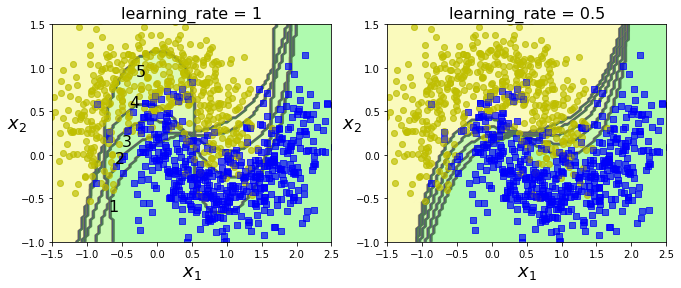

In [109]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights) #set sample weights to 1 at first (normal SVC)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate) #update the sample_weights
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=16)
plt.text(-0.6, -0.10, "2", fontsize=16)
plt.text(-0.5,  0.10, "3", fontsize=16)
plt.text(-0.4,  0.55, "4", fontsize=16)
plt.text(-0.3,  0.90, "5", fontsize=16)
plt.show()


<font colir=red size=4> Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting,
**except that predictors have different weights depending on their overall accuracy on the weighted training set.**<br></font>

<font color=red size=5><br>**WARNING:** There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting. GOOD TO NOTE!!!</font>

## The AdaBoost Algorithm

In AdaBoost;
- **each instance weight is initially set to 1/m.** 
- A first predictor is trained and its **weighted error rate (r)** is computed on the training set. 

#### WEIGHTED ERROR RATE
![](pictures/adabalgo.png)

- The predictor’s weight αj is then computed using the below equation, 
- where η is the learning rate hyperparameter (defaults to 1). 
- **The more accurate the predictor is, the higher its weight will be.** If it is just guessing randomly, then its weight will be close to zero

#### PREDICTOR WEIGHT
![](pictures/adabalgo2.png)



![](pictures/adabalgo3.png)

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found. To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes.

![](pictures/adabalgo4.png)

### There is also a pretty useful AdaBoost numpy implementation here:
https://github.com/jaimeps/adaboost-implementation/blob/master/adaboost.py

### Here is another useful overview:
https://towardsdatascience.com/adaboost-for-dummies-breaking-down-the-math-and-its-equations-into-simple-terms-87f439757dcf

![](pictures/homl_ch07_adaboost2.jpg)




In [110]:
import pandas as pd
# DUMMY DATA 
y_actual = np.array([1,1,1,0,0,1,1,1,1,0,0,0])
y_predic = np.array([1,0,1,1,0,1,0,1,1,0,0,0])

# Convert to form expected by AdaBoost algo
y_actual = np.array([-1 if x==0 else 1 for x in y_actual])
y_predic = np.array([-1 if x==0 else 1 for x in y_predic])

# INITIALIZE WEIGHTS (1/n_samples)
w = np.ones(len(y_predic))/len(y_predic)
sum(w)

1.0

In [111]:
# CALCULATE ERROR RATE (rj)
# (Sum of all weights where classifer misses) / (sum of all weights) 
misses = [int(x) for x in (y_actual != y_predic)]
# Sum of weights for incorrect obs / sum of all weights
r = np.dot(w,misses)/sum(w)
print("Misses:", misses)
print("Weighted error weight of clf (r):", r)

Misses: [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Weighted error weight of clf (r): 0.25


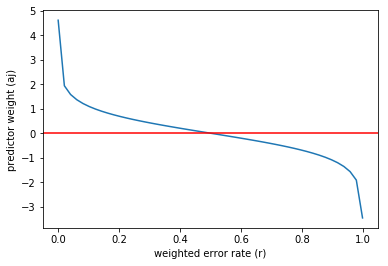

In [112]:
# CALCULATE CLASSIFIER WEIGHT (aj)
n=0.5 # learning rate
def calc_predictor_weight(r, l_rate):
    predictor_w =  l_rate * np.log((1-r)/r)
    return predictor_w

# Test calc_predictor_weight at different values of r
r_rates = np.linspace(0.0001,0.999)
pred_ws = []
for r in r_rates:
    pred_w = calc_predictor_weight(r,n)
    pred_ws.append(pred_w)                   
                   
plt.plot(r_rates, pred_ws)
plt.axhline(0, c='r')
plt.xlabel('weighted error rate (r)')
plt.ylabel('predictor weight (aj)')
plt.show()

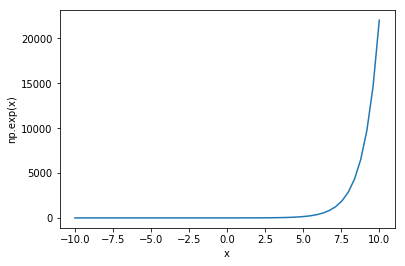

In [113]:
x = np.linspace(-10,10)
y = np.exp(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel('np.exp(x)')
plt.show()

**As you can see, predictors with an r value of 0.5 (random) get predictors weights of zero, and predictors very close to zero get very high values (so they get weighted higher in the next model!)**

In [114]:
# CALCULATE CLASSIFIER WEIGHT (aj)
n=0.5 # learning rate
predictor_weight = calc_predictor_weight(r=r, l_rate=n)

# UPDATE WEIGHTS
# first get list of misses (-1 if incorrect, 1 if correct)
#y_times_hx =  #[-1 if x==1 else 1 for x in misses]
yhat_times_hx = y_actual * y_predic
predw_times_yhatx = -predictor_weight * yhat_times_hx
predw_times_yhatx_exp = np.exp(predw_times_yhatx)
w2 = np.multiply(w, predw_times_yhatx_exp)
w2 = w2/sum(w2)


print("W1 sum:", sum(w))
print("W2 sum:", sum(w2))
print("Learning rate: ", n)
print("Weighted error rate:", r)
print("Predictor weight:", predictor_weight)

pd.DataFrame({"y_actual":y_actual,"y_predict":y_predic,"y*ht(x)":yhat_times_hx,"predw*y*ht(x)":predw_times_yhatx,"exp(predw*y*ht(x))":predw_times_yhatx_exp,"w1":w, "w2":w2})

W1 sum: 1.0
W2 sum: 0.9999999999999998
Learning rate:  0.5
Weighted error rate: 0.999
Predictor weight: -3.4533773893242765


,y_actual,y_predict,y*ht(x),predw*y*ht(x),exp(predw*y*ht(x)),w1,w2
0,1,1,1,3.453377,31.606961,0.083333,0.111074
1,1,-1,-1,-3.453377,0.031639,0.083333,0.000111
2,1,1,1,3.453377,31.606961,0.083333,0.111074
3,-1,1,-1,-3.453377,0.031639,0.083333,0.000111
4,-1,-1,1,3.453377,31.606961,0.083333,0.111074
5,1,1,1,3.453377,31.606961,0.083333,0.111074
6,1,-1,-1,-3.453377,0.031639,0.083333,0.000111
7,1,1,1,3.453377,31.606961,0.083333,0.111074
8,1,1,1,3.453377,31.606961,0.083333,0.111074
9,-1,-1,1,3.453377,31.606961,0.083333,0.111074


In the case of incorrect classification (-1):
- the exp term became larger than 1,
- and the weight is INCREASED 

In the case of correct classification (1):
- the exp term became below 1. 
- and the weight DECREASED

Therefore, incorrect classification would receive higher weights, prompting our classifiers to pay more attention to them in the next iteration, while the opposite case of correct classification would result in the converse.

## Predictor weights
As you can see from the plot below:
- **predcitors with error rates of 0.5 (random guessing) have a PREDICTOR WEIGHT OF ZERO!!!** Meaning that they are shit and should not be heavily weighted in final prediction.
- **predictors with VERY HIGH error rates (very high above 0.5) get LARGE NEGATIVE SCORES!!!** Meaning that they seem to be guessing THE OPPOSITE of what is correct, so go the other way (hence the negative number).
- **predictors with VERY LOW error rates (greatly below 0.5) get LARGE POSITIVE SCORES!!!** Meaning that they are dope and should keep on doing what they are doing. Too legit to quit, as the kids say.

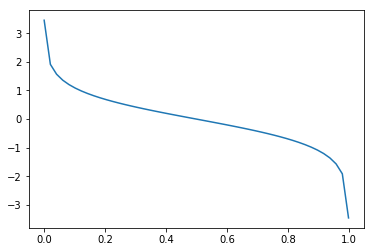

In [115]:
error_rates = np.linspace(0.001,0.999)
predictor_weights = [0.5 * np.log((1-rate)/rate) for rate in error_rates]
plt.plot(error_rates,predictor_weights)
plt.show()

## Sample Weights

If the predictor is very strong (low error rate and high predictor score):
- then incorrect classifications get wights multiplied by a VERY HIGH number
- A missclassifiaciton in a overall strong classifier gets a very high weight boost!

In general, if a classifer is SUPER WEAK OR SUPER STRONG (a very low or very high predictor score), then the exponential term becomes super large... 

![](pictures/homl_ch07_adaboost3.jpg)


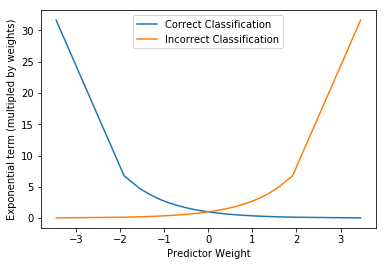

In [116]:
old_weights = np.linspace(0.001,0.2)
exponential_term_correct = np.exp(predictor_weights*np.repeat(-1,len(old_weights)))
exponential_term_incorrect = np.exp(predictor_weights)

plt.plot(predictor_weights, exponential_term_correct, label='Correct Classification')
plt.plot(predictor_weights, exponential_term_incorrect, label='Incorrect Classification')

plt.legend()
plt.xlabel("Predictor Weight")
plt.ylabel("Exponential term (multipled by weights)")

plt.show()

## SAMME: Stagewise Additive Modeling using Multiclass Exponential Loos function

SKlearn actually uses a multiclass version of AdaBoost called SAMME. Which there are just two classes, SAMME is equiv to AdaBoost. ALSO, if the preditors can estimate probabilities (ie if they have a predict_proba() method), then SKL uses a variant of SAMME called SAMME.R, which relies of probabilities rather than predictions AND GENERALLY PERFORMS BETTER. This goes back to the the thing about soft vs hard voting we discussed earlier!!! Neat!

**The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn's AdaBoostClassifier class (though there is also an AdaBoostRegressor!!!!!)**. A Decision Stump is a Decision Tree with max_depth=1, in other words, a tree composed of decision node plus two leaf nodes. THIS IS THE FEAULT BASE ESTIMATOR FOR ADABOOSTCLASSIFIER!!!

**PRO TIP: If AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.**

In [117]:
from sklearn.ensemble import AdaBoostClassifier as ABClassifier
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
mnist = fetch_mldata('MNIST original')

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], test_size=0.5)
print(X_train.shape)
print(y_train.shape)

ada_clf = ABClassifier(base_estimator=DTC(max_depth=1), n_estimators=40, learning_rate=0.5, algorithm='SAMME.R')

ada_clf.fit(X_train, y_train)
ada_clf.estimator_weights_.shape

(35000, 784)
(35000,)


(40,)

## Applying `sample_weights` to Decision Trees

https://www.quora.com/How-does-boosting-works-with-decision-tree-classification-algorithms

There are two ways that this can be done with decision trees: **one that requires modifications to the decision tree algorithm, and one that doesn’t.** Both of them are based on the fact that one of the outputs of boosting is a new weight for each instance, with the training instances that were classified incorrectly increased in weight and all others decreased in weight. So for example, you might end up with one instance having a weight of 1.8 and another with a weight of 0.7.

### Option 1: Reweighting

In this approach, you **modify your in your information gain criteria (or gain ratio or Gini coefficient or whatever your favorite split criteria is) to include the weights of the instance in the computation.** This is usually relatively easy, since reweighting for a weight w say, is essentially the same as having w copies of the same instance (although you can’t have 1.8 copies, the maths doesn’t care about partial copies).

### Option 2: Resampling

If your algorithm is a black box, then you randomly sample with replacement based on the weights. You then feed this into the decision tree classifier. So, for example, the instance with a weight of 1.8 is 1.8/0.7 = 2.6 times more likely to be included in the training set you give to the classifier for building the next level.

**In general, reweighting is preferred, because it has lower variance.**

### Weigthting algorithm with DecisionTrees
https://stackoverflow.com/questions/34389624/what-does-sample-weight-do-to-the-way-a-decisiontreeclassifier-works-in-skle

Recall that a node’s **gini attribute** measures its impurity: 
- a node is “pure” (gini=0) if all training instances it applies to belong to the same class.

![](pictures/gini.png)

For example, in a node with 3 classes remaining, 54 observations, an the depth-2 left node has a gini score equal to 

**1 – (0/54)2 – (49/54)2 – (5/54)2 ≈ 0.168. **

Scikit-Learn uses the **Classification And Regression Tree (CART)** algorithm to train Decision Trees (also called “growing” trees). The idea is really quite simple:
- the algorithm first splits the training set in two subsets using:
    - a single feature: k
    - a threshold: tk (e.g., “petal length ≤ 2.45 cm”). 

**How does it choose k and tk?**
- It searches for the pair (k, tk) that produces the purest subsets (WEIGHTED BY THEIR SIZE, hence the mL/m terms). 
- This means that it tries to optimize for the greatest PURITY for the LARGEST GROUPS


The cost function that the algorithm tries to minimize is given by Equation 6-2.**

![](pictures/Picture37.png)

**Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively.** 
- It stops recursing once it reaches the **maximum depth (defined by the max_depth hyperparameter)**, or if it cannot find a split that will reduce impurity.
- A few other hyperparameters control additional stopping conditions (min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes).

As you can see, the CART algorithm is a **greedy algorithm:**
- it greedily searches for an optimum split at the top level, then repeats the process at each level. 
- It does not check whether or not the split will lead to the lowest possible impurity several levels down. 
- A greedy algorithm often produces a reasonably good solution, but it is not guaranteed to be the optimal solution.

**How does cart change with Rewighting?**

This effectively works by increasing or decreasing the number of observations based on the weights:
- weight of 2 means that a instance would be doubled (thus its probability would be doubled)
- weight of 0.5 means that a instances probability would be half of what it was originally

 `sample_weight : array-like, shape = [n_samples] or None
    Sample weights. If None, then samples are equally weighted. Splits
    that would create child nodes with net zero or negative weight are
    ignored while searching for a split in each node. Splits are also
    ignored if they would result in any single class carrying a
    negative weight in either child node.`
    
From stack overflow: https://stackoverflow.com/questions/34389624/what-does-sample-weight-do-to-the-way-a-decisiontreeclassifier-works-in-skle


The short answer to your question is:
 - sample_weight augments the probability estimates in the probability array ... 
 - which augments the impurity measure ... 
 - which augments how nodes are split ... 
 - which augments how the tree is built ... 
 - which augments how feature space is diced up for classification.

**EXAMPLE:**
I believe this is best illustrated through example. We will consider the following **2-class problem where the inputs are 1 dimensional**. So, we'll look at trees with just a root node and two children. Note that the default impurity measure the gini measure. The data will be as follow:

In [118]:
from sklearn.tree import DecisionTreeClassifier as DTC
X = np.array([[0],[1],[2],[2],[1],[3],[4],[5],[4],[0]]) # 10 simple training examples
Y = np.array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1]) # class labels
dtc = DTC(max_depth=1)
print(X)
print(Y)

[[0]
 [1]
 [2]
 [2]
 [1]
 [3]
 [4]
 [5]
 [4]
 [0]]
[0 0 1 0 0 1 1 1 0 1]


### Case 1: no sample_weight

In [119]:
dtc.fit(X,Y)
print("Threshold: ", dtc.tree_.threshold) # Ignore last two thresholds... they are placeholders and not used
print("Impurity: ", dtc.tree_.impurity)

Threshold:  [ 1.5 -2.  -2. ]
Impurity:  [0.5        0.375      0.44444444]


In [120]:
# LEFT Node
print("TOP node classes:", Y)
print("Gini:",1- (5/10)**2 - (5/10)**2)

# LEFT Node
print("Left node classes:", Y[np.where(X<1.5)[0]])
print("Gini:",1- (1/4)**2 - (3/4)**2)

# RIGHT Node
print("Right node classes:", Y[np.where(X>1.5)[0]])
print("Gini:",1- (4/6)**2 - (2/6)**2)

TOP node classes: [0 0 1 0 0 1 1 1 0 1]
Gini: 0.5
Left node classes: [0 0 0 1]
Gini: 0.375
Right node classes: [1 0 1 1 1 0]
Gini: 0.4444444444444445


- The first value in the threshold **(1.5)** array tells us that:
    - left node: 4 training example [0,1,4,9] are sent to the left child node, with classes [0,0,0,1]
    - right node: 6 training examples [2,3,5,6,7,8] are sent to the right child node, with classes [1,0,1,1,1,0]
- The last two values in threshold are placeholders and are to be ignored. 
- The impurity array tells us the computed impurity values in the parent, left, and right nodes respectively.

### Case 2: with sample_weight
Ok, so we asusme that weights from first model were all ones (one oberservation has weight of 1... makes sense!). Then when we update the weights, each observation is multipled by its weight, so a single obsevation could end up being worth morth or less than one in the impurity calculations!

So before, if you had 3 observations, the gini input would take in 3. But if you reduce their weights to 0.75, then the gini function takes in a value of 2.25 for that class.

In [121]:
# Boost weights of 1s, reduce weights of 0s
print("Weights before:", np.ones(len(Y)))
sample_weights = np.array([1,2,4,1,2,3,3,4,8,5])
w_sum = sample_weights.sum()
print("Weights after:", sample_weights)

Weights before: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Weights after: [1 2 4 1 2 3 3 4 8 5]


Sample_weight affects the impurity measure in each node. Specifically, in the probability estimates:
- the first training example is counted as 1 (same as before) 
- the second is counted double (weight of 2) 
- the third is counted as 4 times as important (weight as 4)
- the Nth training instance is counted as sample_weights\[N\] times more/less important

In [122]:
# Fit new model with sample weights
dtc.fit(X,Y,sample_weight=sample_weights)
print("Thresholds:", dtc.tree_.threshold)
print("Impurities:", dtc.tree_.impurity)

Thresholds: [ 4.5 -2.  -2. ]
Impurities: [0.48852158 0.49940547 0.        ]


In [123]:
# LEFT Node
print("TOP node classes:", Y)
class_1 = sum(sample_weights[np.where(Y==1)[0]])
class_0 = sum(sample_weights[np.where(Y==0)[0]])
print("Gini:",1- (class_1/w_sum)**2 - (class_0/w_sum)**2)

# LEFT Node
print("Left node classes:", Y[np.where(X<4.5)[0]])
print("Gini:",1- (5/9)**2 - (4/9)**2)

# RIGHT Node
print("Right node classes:", Y[np.where(X>4.5)[0]])
print("Gini:",1- (0/1)**2 - (1/1)**2)

TOP node classes: [0 0 1 0 0 1 1 1 0 1]
Gini: 0.48852157943067026
Left node classes: [0 0 1 0 0 1 1 0 1]
Gini: 0.49382716049382713
Right node classes: [1]
Gini: 0.0


## Applying `sample_weights` to  Support Vector Machines


See link for more info: https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems

In problems where it is desired to give more importance to certain classes or certain individual samples keywords `class_weight` and `sample_weight` can be used. **Note that in AdaBoost, we only use `sample_weight` (I think?!?!), but will discuss both here.**

#### Class weighting:
- SVC (but not NuSVC) implements a keyword `class_weight` in the fit method. 
- It’s a dictionary of the form `{class_label : value}`, where value is a floating point number > 0 that sets the parameter C of class class_label to C * value. This results in `C[i] = C * class_weight[class[i]]`
- So essentially when we have class imbalances, we can increase the C param for certain classes by multiplying it by a higher class_weight param. Recall that larger C means a smaller slack parameter, which means a tighter fitting street (harder/smaller margin)! This forces the classifier to get higher weighted class right!  

#### Sample weighting:
- SVC, NuSVC, SVR, NuSVR and OneClassSVM also implement weights for individual samples in method fit through keyword `sample_weight`. Similar to class_weight, these set the parameter `C` for the i-th example to `C[i] = C * sample_weight[i].`

#### Class and sample weighting:
- In summary, the C parameter changes to `C[i]`, where `i` is index of sample. Each `C[i]` is `C[i] = C * sample_weight[i] * class_weight[class[i]]`

Let's test this out. First we will create an imbalanced dataset using sklearns make_moons function:

X: (550, 2)
y: (550,)


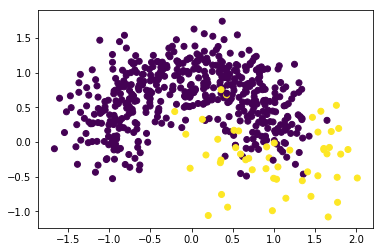

In [124]:
random_state=42
# IMPORT DATASET
X, y = make_moons(n_samples=1000, noise=0.30, random_state=random_state)

# Reduce y=0 class by 90%
del_idx = np.where(y==1)[0][:450]
X_imbal = np.delete(X,del_idx, axis=0)
y_imbal = np.delete(y,del_idx, axis=0)

print("X:", X_imbal.shape)
print("y:", y_imbal.shape)
plt.scatter(X_imbal[:,0], X_imbal[:,1], c=y_imbal)
plt.show()

**Build a somewhat regularized model (low C and gamma params) so that we misclassify many of the 1s (the unbalanced class)**

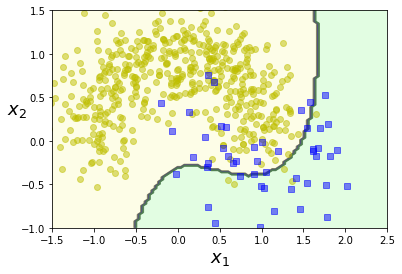

In [125]:
from sklearn.svm import SVC
clf_svc = SVC(kernel='rbf', C=3, gamma=0.5, probability=True)
clf_svc.fit(X_imbal,y_imbal)
plot_decision_boundary(clf_svc, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True)

In [126]:
clf_svc.predict_proba([[-1.5,1.5]])

array([[0.88429294, 0.11570706]])

In [127]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
conf_mat = confusion_matrix(clf_svc.predict(X_imbal), y_imbal)

# Print confusion matrix, precision score, and recall score
def print_score(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    return pd.DataFrame(conf_mat, index=['0_true','1_true'], columns = ['0_pred','1_pred'])

print_score(y_imbal, clf_svc.predict(X_imbal))

Precision: 0.8387096774193549
Recall: 0.52


,0_pred,1_pred
0_true,495,5
1_true,24,26


**Note that we have a fairly solid precision score, but our recall score is much lower.**
- High precision: **Of all the classes we identify as positive (1), ~84% of them are correct.
- Low recall: **Of ALL OF THE POSITIVE cases in the dataset (1), we only identified 52%**... not very good, especially if we are trying to screen people for diseases...

**Addressing the class imbalance**

Also, we seem to be getting most of the majority class (0s) right... But its the imbalanced class we are having issues with! One way to address this is to use `class_weight` and `sample_weights` params.

First lets adjust the contour plot funciton:

In [128]:
#ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='red'):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['white', line_color,'white'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)#colors=['red'])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    

### Class weight adjustment

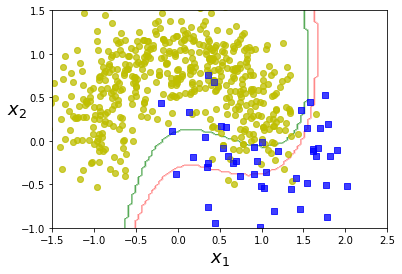

In [129]:
# Class_weight adjusted classifier
from sklearn.svm import SVC
clf_svc_cw = SVC(kernel='rbf', C=3, gamma=0.5, probability=True, class_weight={0:0.5, 1:2})
clf_svc_cw.fit(X_imbal, y_imbal)
# Plot regular classifier in RED
plot_decision_boundary(clf_svc, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='red')
# Plot class weights adjusted classifier in GREEN
plot_decision_boundary(clf_svc_cw, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='green')

### Sample weights adjustment

In [130]:
# First create sample weights using predictions from original clf_svc
# Missclassified samples go up by 100% to 2
# Properly classified examples go down by 50% to 0.5
preds = clf_svc.predict(X_imbal)
acc = preds==y_imbal

# Initialize weights to vector of ones
sample_weights=np.ones(len(preds))
# Reduce weights of correct samples by 50%
sample_weights[np.where(acc==True)] *= 0.5
# Increase weights of incorrect samples by 100%
sample_weights[np.where(acc==False)] *= 2

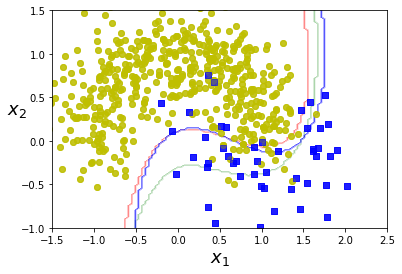

In [131]:
# Train new sample_weights adjusted model
from sklearn.svm import SVC
clf_svc_sw = SVC(kernel='rbf', C=3, gamma=0.5, probability=True)
clf_svc_sw.fit(X_imbal, y_imbal, sample_weight=sample_weights)

# Plot regular classifier in RED
plot_decision_boundary(clf_svc, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='green')
# Plot class weights adjusted classifier in GREEN
plot_decision_boundary(clf_svc_cw, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='red')
# Plot sample weights classifier in BLUE
plot_decision_boundary(clf_svc_sw, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='blue')

### Class weights AND Sample weights

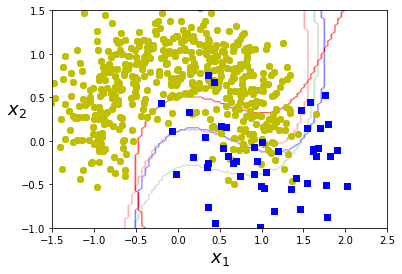

In [132]:
from sklearn.svm import SVC
clf_svc_cw_sw = SVC(kernel='rbf', C=3, gamma=0.5, probability=True, class_weight={0:0.5, 1:2})
clf_svc_cw_sw.fit(X_imbal, y_imbal, sample_weight=sample_weights)

# Plot regular classifier in RED
plot_decision_boundary(clf_svc, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='green')
# Plot class weights adjusted classifier in GREEN
plot_decision_boundary(clf_svc_cw, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='red')
# Plot sample weights classifier in BLUE
plot_decision_boundary(clf_svc_sw, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, line_color='blue')
# Plot sample weights classifier in DARK RED
plot_decision_boundary(clf_svc_cw_sw, X_imbal, y_imbal, axes=[-1.5, 2.5, -1, 1.5], alpha=1, line_color='red')

#### We can see how the contour lines move up to correctly classify 1s much better when we add class_weights and sample_weights, and even moreso when we apply both. 

However, in each case we misclassify many more zeros. This might be okay, if we are just looking to have a very high Recall rate, like if we are scanning for diseases or incidences of fraud, for exampl. In these cases, we do not care as much about a low precision rate, we just want to make sure we capture every potential positive case.   

## AdaBoost documentation
`Init signature: AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)`

An AdaBoost [1] classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.**This class implements the algorithm known as AdaBoost-SAMME.**

#### Parameters
base_estimator : object, optional (default=DecisionTreeClassifier)
- The base estimator from which the boosted ensemble is built. 
- **Support for sample weighting is required,** as well as proper `classes_` and `n_classes_` attributes.

n_estimators : integer, optional (default=50)
- The maximum number of estimators at which boosting is terminated.
- In case of perfect fit, the learning procedure is stopped early.

learning_rate : float, optional (default=1.)
- Learning rate shrinks the contribution of each classifier by``learning_rate``. 
- There is a trade-off between ``learning_rate`` and ``n_estimators``.

algorithm : {'SAMME', 'SAMME.R'}, optional (default='SAMME.R')
- If 'SAMME.R' then use the SAMME.R real boosting algorithm. ``base_estimator`` must support calculation of class probabilities.
- If 'SAMME' then use the SAMME discrete boosting algorithm.
- The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.

random_state : int, RandomState instance or None, optional (default=None)
- If int, random_state is the seed used by the random number generator;
- If RandomState instance, random_state is the random number generator;
- If None, the random number generator is the RandomState instance used by `np.random`.

#### Attributes
estimators\_ : list of classifiers
- The collection of fitted sub-estimators.

classes\_ : array of shape = [n_classes]
- The classes labels.

n\_classes\_ : int
- The number of classes.

estimator\_weights\_ : array of floats
- Weights for each estimator in the boosted ensemble.

estimator\_errors\_ : array of floats
- Classification error for each estimator in the boosted ensemble.

feature\_importances\_ : array of shape = [n_features]
- The feature importances if supported by the ``base_estimator``.

# Gradient Boosting

Another very popular Boosting algo is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

Let's go through a simple regression workflow using DTs, this is called Gradient Tree Boosing, or Gradient Booster Regression Trees (GBRTs). 

1. First we will create a base estimator... this will just predict the mean of the y values (the next predictors will effecitvely be trying to predcit how far from the mean an observation is!). This is what sklearn's defaults gradient boosting implementaiton does, but you can set it to something else by changing the `init` parameter.
2. Second we fit a DecisionTreeRegressor to predict the variance from the mean of each observation... this is the residual!
3. Then train a second DTR on the residual errors made by the second predictor
4. Then we train a third regressor on the residual errors made by the second predictor
5. Repeat the residual prediction for as many trees as you deem fit.

## GBR Custom Implementation

Before we use sklearns implementation of Gradient Boosting, let's build our own custom implemtnation using Decision Trees. 

First, lets create a simple dummy dataset:

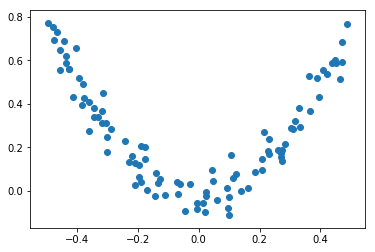

In [133]:
#create quadratic data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.07 * np.random.randn(100)
plt.scatter(X,y)
plt.show()

In [134]:
#train tree 1
from sklearn.tree import DecisionTreeRegressor

# BASE ESTIMATOR: 
# Set each prediction to the mean (this is something that the sklearn does too, creates a good starting point)
# Again, this base estimator can be changed with the init parameter in sklearns Gradient Boosting algo
base_estimator_pred = np.ones(len(y))*np.mean(y)
base_res = y - base_estimator_pred

# TREE 1: Train on residuals of base estimator
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, base_res)
t1_res = base_res - tree_reg1.predict(X)

# TREE 2: Train on residuals of tree 1
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,t1_res)
t2_res = t1_res - tree_reg2.predict(X)

# TREE 3: Train on residuals of tree 2
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, t2_res)
t3_res = t2_res - tree_reg3.predict(X)

In [135]:
# Make predictions on a new instance simply by adding up the predictions of all the trees
X_new = np.array([[0.1]]) #new X values
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))

# Add each prediciton cummulatively (start with mean as base prediction)
pred_ = np.mean(y)
for i, tree in enumerate([tree_reg1,tree_reg2,tree_reg3]):
    pred_single = tree.predict(X_new)
    pred_ += pred_single
    print("Residual predict:", pred_single, "------- Cumulative Prediction at Tree {}".format(i), pred_)

Residual predict: [-0.14447811] ------- Cumulative Prediction at Tree 0 [0.12095868]
Residual predict: [-0.0932507] ------- Cumulative Prediction at Tree 1 [0.02770798]
Residual predict: [0.00723337] ------- Cumulative Prediction at Tree 2 [0.03494135]


## GBR Sklean Implementation for Regression
A simpler way to train a **Gradient Boosting Residual Tree (GBRT)** is to use GradientBoostingRegressor in SKL. Much like Randomforest, it has hyperparams to control growth of the trees, as well as the number of trees (n_estimators). The following code recreates the previous code but is much easier!!!

- You can use **staged_predict** method to produce cummulative predictions from each estimator (more on this below). It creates a generator item that can process each estimators prediction one at a time
- You can also access individual predictors by using the models **estimators_** method
- We will use these two methods to **replicate the results from above!!!**

In [136]:
from sklearn.ensemble import GradientBoostingRegressor
# Initialize GBR with leastSquares loss function ('ls')
gbrt = GradientBoostingRegressor(loss = 'ls', max_depth=2, n_estimators=3, learning_rate=1, max_features='sqrt', criterion='friedman_mse')
gbrt.fit(X,y)

# Use staged predict to print out prediction at each tree
for i, pred_gbm in enumerate(gbrt.staged_predict(X_new)):
    pred_single = gbrt.estimators_[i][0].predict(X_new)
    print("Residual predict:", pred_single, "------- Cumulative Prediction at Tree {}".format(i), pred_gbm)    

Residual predict: [-0.14447811] ------- Cumulative Prediction at Tree 0 [0.12095868]
Residual predict: [-0.0932507] ------- Cumulative Prediction at Tree 1 [0.02770798]
Residual predict: [0.00723337] ------- Cumulative Prediction at Tree 2 [0.03494135]


### Base Estimators

Below is the documentation for default base estimator for GradientBoostingRegressor:

```init : BaseEstimator, None, optional (default=None) An estimator object that is used to compute the initial predictions. init has to provide fit and predict. If None it uses loss.init_estimator.```

Note that if you do not specify a base estimator, the algo will automatically use the base estimator specified by the loss class that you have chosen. For the `LeastSquaresError` loss class (the deafult loss class for GradientBoostingRegressor), the base estimator is `MeanEstimator` which simply predicts the mean:

```python
class MeanEstimator(object):
    """An estimator predicting the mean of the training targets."""
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            self.mean = np.mean(y)
        else:
            self.mean = np.average(y, weights=sample_weight)

    def predict(self, X):
        check_is_fitted(self, 'mean')

        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.mean)
        return y
```

### Loss classes
As mentioned above, the default loss class for the GradientBoosingRegressor aglo is `ls`, which is the LeastSquaresError function. However you can choose from several others:

- **'ls'** (default) refers to least squares regression
- **'lad'** (least absolute deviation) is a highly robust loss function solely based on order information of the input
    variables. 
- **'huber'** is a combination of the two. 
- **'quantile'** allows quantile regression (use 'alpha' to specify the quantile).


Each loss type is a seperate class declared in the `gradient_boosting.py` code... You can find the implementations there if you want more details! Here is the code for the LeastSquaresErros loss class (dig more into the parent classes for the full picture):

```python
class LeastSquaresError(RegressionLossFunction):
    """Loss function for least squares (LS) estimation. Terminal regions need not to be updated for least squares. """  
    def init_estimator(self):
        return MeanEstimator()

    def __call__(self, y, pred, sample_weight=None):
        if sample_weight is None:
            return np.mean((y - pred.ravel()) ** 2.0)
        else:
            return (1.0 / sample_weight.sum() * np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))

    def negative_gradient(self, y, pred, **kargs):
        return y - pred.ravel()

    def update_terminal_regions(self, tree, X, y, residual, y_pred,sample_weight, sample_mask, learning_rate=1.0, k=0):
        """Least squares does not need to update terminal regions.But it has to update the predictions."""
        # update predictions
        y_pred[:, k] += learning_rate * tree.predict(X).ravel()

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y, residual, pred, sample_weight):
        pass
```


## Plotting Residuals
The plots above represent the predictions of the three trees on the left (first ensemble and then residuals), AND the ensembles predictions on the right! 

**On the right you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. Similarily, in the third row another tree is training on the residual errors you see in the seocnd tree!**

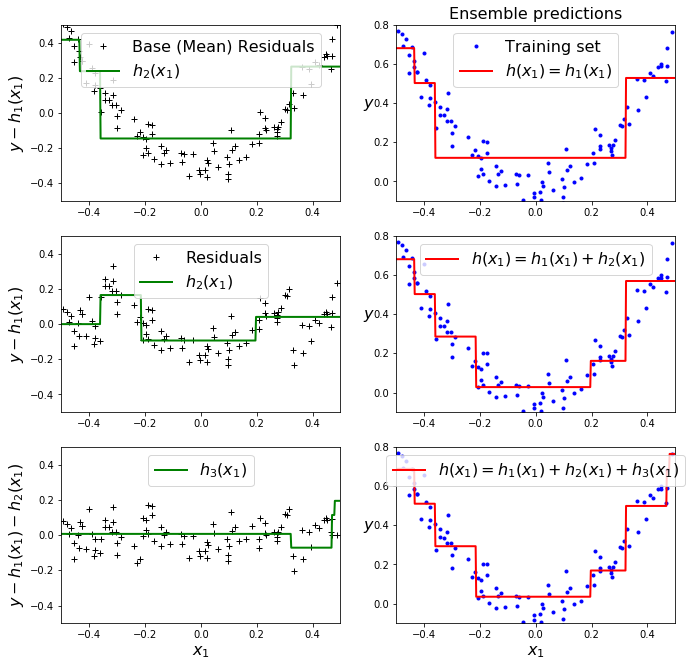

In [137]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None, add_mean=True):
    x1 = np.linspace(axes[0], axes[1], 500)
    # MAKE SURE TO ADD MEAN FROM BASE REGRESSOR!!!
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    if add_mean:
        y_pred+=np.mean(y)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, base_res, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Base (Mean) Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, t1_res, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, t3_res, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

## Shrinkage and the GBT Learning Rate

Now, you may have notice I used a **learning rate hyperparameter** above. This is used to scale the contribution of each tree. If you set it to a low value such as 0.1, you will need MORE trees in the ensemble to fit the training set... BUT the predictions will usually generalize better. **This is a regularization technique called 'Shrinkage'**. The graph below shoes two GBRT ensembles trianined with a low learning rate: 
- the one on the left does NOT have enough trees to fit the training set
- while the one on the right has TOO MANY trees and overfits the training set

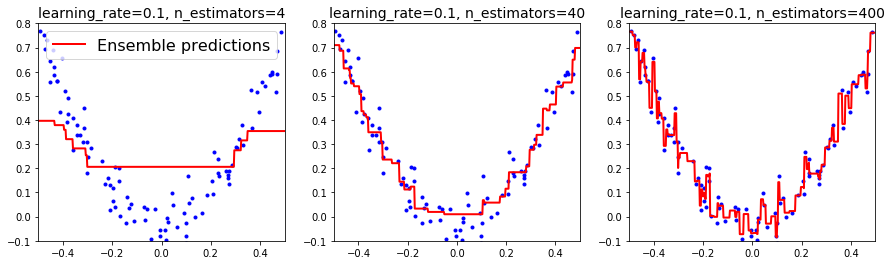

In [138]:
from sklearn.ensemble import GradientBoostingRegressor

#4 estimators
gbrt1 = GradientBoostingRegressor(max_depth=2,n_estimators=4,learning_rate=0.1,random_state=42)
gbrt1.fit(X,y)
#40 estimators
gbrt2 = GradientBoostingRegressor(max_depth=2,n_estimators=40,learning_rate=0.1,random_state=42)
gbrt2.fit(X,y)
#400 estimators
gbrt3 = GradientBoostingRegressor(max_depth=2,n_estimators=400,learning_rate=0.1,random_state=42)
gbrt3.fit(X,y)

plt.figure(figsize=(15,4))
plt.subplot(131)
plot_predictions([gbrt1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions", add_mean=False)
plt.title("learning_rate={}, n_estimators={}".format(gbrt1.learning_rate, gbrt1.n_estimators), fontsize=14)
plt.subplot(132)
plot_predictions([gbrt2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], add_mean=False)
plt.title("learning_rate={}, n_estimators={}".format(gbrt2.learning_rate, gbrt2.n_estimators), fontsize=14)
plt.subplot(133)
plot_predictions([gbrt3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], add_mean=False)
plt.title("learning_rate={}, n_estimators={}".format(gbrt3.learning_rate, gbrt3.n_estimators), fontsize=14)
plt.show()

A couple points to mention here:
- As you will see below, we multiply each prediction value by the learning rate and subtract that product from the previous models predictions to get our new residuals... this means that only a portion of each prediction (controlled by the learning rate) is added to the final prediction. So if our first tree was off by 10, and we have a learning rate of 0.1 (resulting in a residual of 1, opposed to 10), this means that our next model will be looking to predict a value of -1 for this observation... This is too low a value to make up for real error, so we need to add more predictors to make up for this!
- Remember that each tree tries to predict the residuals of the previous model in the sequence... and our first model is generally going to be the mean predictor (a constant)... and **the smaller our learning rate is, the closer to the base estimator our models final prediction will be** (depening on the number of estimators we use of course)
- It can be tough to predict the perfect learning rate, so cross validation can come in super handy here!

#### Let's implement the learning rate parameter ourselves using the same custom implementation from above:

In [139]:
X_new

array([[0.1]])

In [140]:
learning_rate = 0.1

# BASE ESTIMATOR: 
base_estimator_pred = np.ones(len(y))*np.mean(y)
base_res = y - base_estimator_pred

# TREE 1: Train on residuals of base estimator
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, base_res)
t1_res = base_res - (tree_reg1.predict(X) * learning_rate) # MULTIPLY BY LEARNING RATE

# TREE 2: Train on residuals of tree 1
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, t1_res)
t2_res = t1_res - (tree_reg2.predict(X) * learning_rate) # MULTIPLY BY LEARNING RATE

# TREE 3: Train on residuals of tree 2
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, t2_res)
t3_res = t2_res - (tree_reg3.predict(X) * learning_rate) # MULTIPLY BY LEARNING RATE

# Add each prediciton cummulatively (start with mean as base prediction)
pred_ = np.mean(y)
for i, tree in enumerate([tree_reg1,tree_reg2,tree_reg3]):
    pred_single = tree.predict(X_new)# * learning_rate 
    pred_ += pred_single
    print("Residual predict:", pred_single, "------- Cumulative Prediction at Tree {}".format(i), pred_)

Residual predict: [-0.14447811] ------- Cumulative Prediction at Tree 0 [0.12095868]
Residual predict: [-0.16761234] ------- Cumulative Prediction at Tree 1 [-0.04665367]
Residual predict: [-0.14014714] ------- Cumulative Prediction at Tree 2 [-0.18680081]


In [141]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, max_features='sqrt', criterion='friedman_mse')
gbrt.fit(X,y)

# Use staged predict to print out prediction at each tree   
for i, pred_gbm in enumerate(gbrt.staged_predict(X_new)):
    pred_single = gbrt.estimators_[i][0].predict(X_new)
    print("Residual predict:", pred_single, "------- Cumulative Prediction at Tree {}".format(i), pred_gbm)    

Residual predict: [-0.14447811] ------- Cumulative Prediction at Tree 0 [0.25098898]
Residual predict: [-0.16761234] ------- Cumulative Prediction at Tree 1 [0.23422774]
Residual predict: [-0.14014714] ------- Cumulative Prediction at Tree 2 [0.22021303]


#### Also note that residuals get increasingly close to zero as you add models
- With a lower learning rate, the residuals remain higher for longer, because by multiplying the predictions by a small decimal you are forcing subsequent models to predict higher values

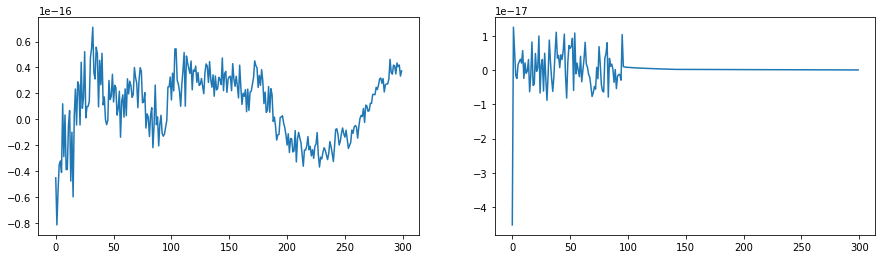

In [142]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt_test1 = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.01, random_state=42)
gbrt_test1.fit(X,y)
gbrt_test2 = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=1, random_state=42)
gbrt_test2.fit(X,y)

residuals1 = [np.mean(estimator[0].predict(X)) for estimator in gbrt_test1.estimators_]
residuals2 = [np.mean(estimator[0].predict(X)) for estimator in gbrt_test2.estimators_]

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(residuals1)
plt.subplot(122)
plt.plot(residuals2)

## Early Stopping with `staged_predict()`

In order to find the optimal number of trees you can implement early stopping!!! A simple way to do so is to use staged_predict() method: 
- it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, three trees, etc.),. 

The following code trains a GBRT ensemble with 120 trees, then measures the validations error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

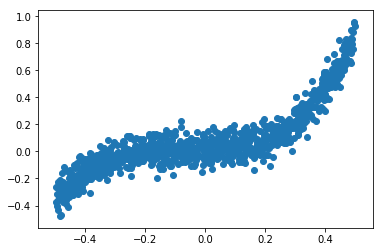

In [143]:
# First get some more data
np.random.seed(42)
X = np.random.rand(1000, 1) - 0.5
y = 5*X[:, 0]**3 + X[:,0]**2 + 0.07 * np.random.randn(1000)
plt.scatter(X,y)
plt.show()

In [144]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=2)

gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=120, random_state=46)
gbrt.fit(X_train, y_train)

#get errors at each stage (should return 120 error vals!)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
min_error = np.min(errors)
print("Min error:", min_error)

#extract number of models with best val score (lowest MSE)
best_n_estimators = np.argmin(errors)
print("Best num of trees:", best_n_estimators)

#run new model using 'best_n_estimators' (which should provide lowest val score!)
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = best_n_estimators)

# Cross val with best estimator!
print("Cross validation error:", np.mean(cross_val_score(gbrt_best, X_train, y_train)))

Min error: 0.004820913260428357
Best num of trees: 45
Cross validation error: 0.9163707613742337


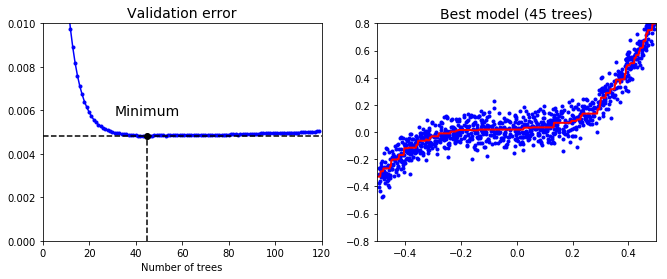

In [145]:
gbrt_best.fit(X_train, y_train)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.8, 0.8], add_mean=False)
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)

plt.show()

#### Also notice how the individual estimator average becomes close to zero at around the same location as the best estimator identified above

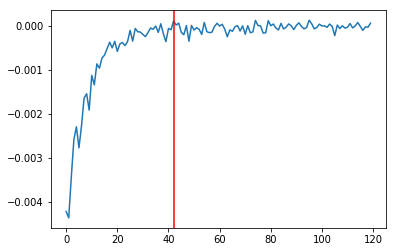

In [146]:
residuals2 = [np.mean(estimator[0].predict(X)) for estimator in gbrt.estimators_]
plt.plot(residuals2)
plt.axvline(42,c='red')

## Early stopping with `warm_start`

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of training and selecting the lowest error value).

You do so by setting **warm_start=True**, which makes SKL keep existing trees when the fit() mehtod is called, allowing incremental training. The following code stops training when the validaiton error does not improve for fiver iterations in a row:

In [147]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,300):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if n_estimators%10==0:
        print("Estimators trained: {0}, mse = {1}".format(n_estimators, val_error))
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 10:
            print("Final model trained at {0} estimators".format(n_estimators))
            break #early stopping

Estimators trained: 10, mse = 0.01574326690223082
Estimators trained: 20, mse = 0.006978476491668303
Estimators trained: 30, mse = 0.0053228798033804
Estimators trained: 40, mse = 0.004943445512231673
Estimators trained: 50, mse = 0.004847889146829378
Estimators trained: 60, mse = 0.004846249984076302
Final model trained at 67 estimators


## Stochastic Gradient Boosting

The GradientBoostingRegressor class also supports a **subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree.** For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, **this trades a higher bias for a lower variance. It also speeds up training considerably.** This technique is called Stochastic Gradient Boosting.

In [155]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt_sg = GradientBoostingRegressor(loss='ls', max_depth=2, n_estimators=100, subsample=0.25)
gbrt_sg.fit(X,y)
cross_val_score(gbrt_sg, X, y)

array([0.91863274, 0.92915176, 0.90721726])

In [187]:
?GradientBoostingClassifier

# GB Sklearn implementation for Classification

` GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto') `


### Base Estimators

Below is the documentation for default base estimator for GradientBoostingClassifier. Note that it is the same as the documentiton for the GradientBoostingRegressor:

`init : BaseEstimator, None, optional (default=None) An estimator object that is used to compute the initial predictions. init has to provide fit and predict. If None it uses loss.init_estimator.`

Just as with the GB regressor, if you do not specify a base estimator, the algo will automatically use the base estimator specified by the loss class that you have chosen. For the `deviance` loss class (the deafult loss class for GradientBoostingClassifier), the base estimator is LogOddsEstimator which simply predicts the log odds ratio:

``` python
class LogOddsEstimator(object):
    """An estimator predicting the log odds ratio."""
    scale = 1.0

    def fit(self, X, y, sample_weight=None):
        # pre-cond: pos, neg are encoded as 1, 0
        if sample_weight is None:
            pos = np.sum(y)
            neg = y.shape[0] - pos
        else:
            pos = np.sum(sample_weight * y)
            neg = np.sum(sample_weight * (1 - y))

        if neg == 0 or pos == 0:
            raise ValueError('y contains non binary labels.')
        self.prior = self.scale * np.log(pos / neg)

    def predict(self, X):
        check_is_fitted(self, 'prior')

        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.prior)
        return y
```


#### Here is what the log odds look like: 
- Remember that odds are calculated as n_pos_class / n_neg_class
- With totally balanced classes (odds of 1), log odds == 0.
- With highly imballanced class (neg far outwiehgts pos class), odds are a very small decimal, and log odds are very low negative. 

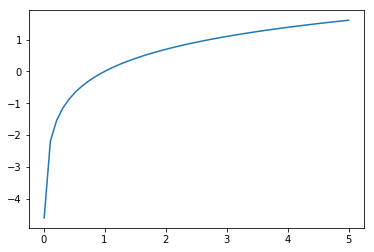

In [186]:
odds = np.linspace(0.01,5)
plt.plot(odds, np.log(odds))


### Loss functions

As mentioned above, the `loss` parameter in the gradient boosting initialization is used to set the loss function you want to use. For classification, we use the `GradientBoostingClassifier`, with a new set of potential loss functions:
- **'deviance'** (default) refers to deviance (= logistic regression) for classification with probabilistic outputs. 
- **'exponential'** refers to exponential gradient boosting which recovers the AdaBoost algorithm

If you select 'deviance' as your loss class, the model will set your loss class to `BinomialDeviance` for binary classifiers, and `MultinomialDeviance` for multi-class classifiers. Below is the sklearn code for the BinomialDeviance class:

```python
class BinomialDeviance(ClassificationLossFunction):
    """Binomial deviance loss function for binary classification.

    Binary classification is a special case; here, we only need to
    fit one tree instead of ``n_classes`` trees.
    """
    def __init__(self, n_classes):
        if n_classes != 2:
            raise ValueError("{0:s} requires 2 classes.".format(
                self.__class__.__name__))
        # we only need to fit one tree for binary clf.
        super(BinomialDeviance, self).__init__(1)

    def init_estimator(self):
        return LogOddsEstimator()

    def __call__(self, y, pred, sample_weight=None):
        """Compute the deviance (= 2 * negative log-likelihood). """
        # logaddexp(0, v) == log(1.0 + exp(v))
        pred = pred.ravel()
        if sample_weight is None:
            return -2.0 * np.mean((y * pred) - np.logaddexp(0.0, pred))
        else:
            return (-2.0 / sample_weight.sum() *
                    np.sum(sample_weight * ((y * pred) - np.logaddexp(0.0, pred))))

    def negative_gradient(self, y, pred, **kargs):
        """Compute the residual (= negative gradient). """
        return y - expit(pred.ravel())

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, pred, sample_weight):
        """Make a single Newton-Raphson step.

        our node estimate is given by:

            sum(w * (y - prob)) / sum(w * prob * (1 - prob))

        we take advantage that: y - prob = residual
        """
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        numerator = np.sum(sample_weight * residual)
        denominator = np.sum(sample_weight * (y - residual) * (1 - y + residual))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

    def _score_to_proba(self, score):
        proba = np.ones((score.shape[0], 2), dtype=np.float64)
        proba[:, 1] = expit(score.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _score_to_decision(self, score):
        proba = self._score_to_proba(score)
        return np.argmax(proba, axis=1)
```

A few notes:
- The negative gradient is now `y - expit(y_pred)`, where `expit` is scipi's implementation of the logit (sigmoid) function.
- `_update_terminal_region` implements a single step of Newton_Raphson step method, which is also known as line search. This essentially finds a optimal parameter to multiply the prediction from each leaf of the tree, further improving each trees prediction accuracy. The formula is actually pretty simple here:
    - use the decision tree `apply(X)` method to return the leaf node for each x value.
    - isolate the observations from a single leaf node as `y`
    - perform the calculation: `sum(w * (y - prob)) / sum(w * prob * (1 - prob))`
    - assign the new alue 
    - this is looped over for ever leaf node in the tree, 

### Testing out helped function
- scipy.expit() for sigmoid
- dt.apply() to access tree leaves
- 

### Use DTRegressor as classification tool
- If you dig into the code, you'll notice that sklearn uses a DT Regressor, not a DT Classifier!

array([0.1091314 , 0.88571429, 0.88571429, 0.88571429, 0.1091314 ,
       0.88571429, 0.88571429, 0.1091314 , 0.88571429, 0.1091314 ,
       0.88571429, 0.1091314 , 0.88571429, 0.88571429, 0.88571429,
       0.88571429, 0.1091314 , 0.88571429, 0.88571429, 0.1091314 ,
       0.88571429, 0.1091314 , 0.1091314 , 0.1091314 , 0.1091314 ,
       0.1091314 , 0.1091314 , 0.97826087, 0.88571429, 0.97826087,
       0.1091314 , 0.1091314 , 0.88571429, 0.1091314 , 0.06      ,
       0.1091314 , 0.88571429, 0.88571429, 0.88571429, 0.88571429,
       0.1091314 , 0.1091314 , 0.1091314 , 0.97826087, 0.1091314 ,
       0.1091314 , 0.88571429, 0.88571429, 0.06      , 0.88571429,
       0.88571429, 0.88571429, 0.1091314 , 0.88571429, 0.1091314 ,
       0.88571429, 0.88571429, 0.88571429, 0.1091314 , 0.88571429,
       0.1091314 , 0.88571429, 0.06      , 0.1091314 , 0.88571429,
       0.88571429, 0.88571429, 0.88571429, 0.88571429, 0.88571429,
       0.1091314 , 0.06      , 0.88571429, 0.88571429, 0.10913

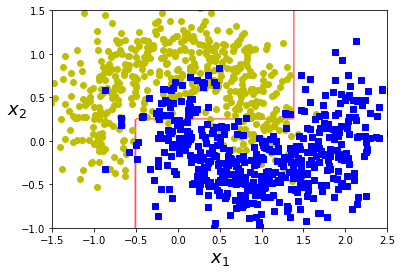

In [273]:
### Using the dt.apply(X) method
from sklearn.tree import DecisionTreeRegressor as dt
dt = dt(max_depth=2)
dt.fit(X,y)

# This should produce the nodes of each tree
#dt.apply(X)
#dt.children_left
plot_decision_boundary(dt, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=1, line_color='red')
dt.predict(X)

#### Lets implement this with sklearn

First lets create a dataset:

X: (1000, 2)
y: (1000,)


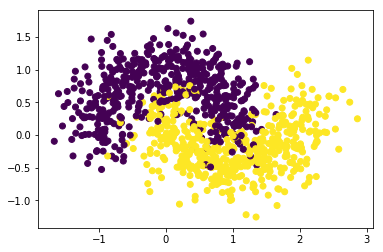

In [192]:
random_state=42
# IMPORT DATASET
X, y = make_moons(n_samples=1000, noise=0.30, random_state=random_state)

print("X:", X.shape)
print("y:", y.shape)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

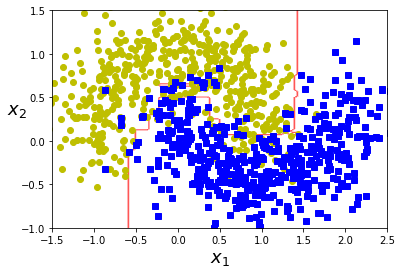

In [265]:
from sklearn.ensemble import GradientBoostingClassifier as gbclf
gbc = gbclf(loss='deviance', n_estimators=120, max_depth=2, learning_rate=0.1)
gbc.fit(X,y)
plot_decision_boundary(gbc, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=1, line_color='red')

In [264]:
gbc.estimators_[0][0].tree_

In [263]:
dir(gbc.estimators_[0][0])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_get_param_names',
 '_validate_X_predict',
 'apply',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_classes_',
 'n_features_',
 'n_outputs_',
 'predict',
 'presort',
 'random_state',
 'score',
 'set_params',
 'splitter',
 'tree_']

In [218]:
# Because we have balanced classes, base estimator prediction (log(odds)) should be zero
gbc.init_.predict(X)[0:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [246]:
gbc.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=2,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000002C54B528510>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=2,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000002C54B528510>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=2,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_

# More on gradient boosting from Quora
https://www.quora.com/What-is-an-intuitive-explanation-of-Gradient-Boosting

We start with a function to minimize. We want a function whose value increases with how bad the classifier/regressor is. For a general treatment, we refer to this function as the loss function represented by L. **For Gradient Boosting loss functions must be differentiable.** An example is the squared error between the actual and predicted value i.e. $L=  (y_i - h(x))^2$ 

We want to minimize $f(x)=  \Sigma_{i=1}^{N} L (y_i - h(x))^2$ i.e. the loss over all points (xi,yi). Here:
- $h(x)$ is the classifier/regressor; which for brevity we'll refer to as the predictor
- $N$ is the total number of points

In a traditional example of Gradient Descent we want to minimize the loss function wrt $W$ (the weight values). So what are we minimizing wrt here? **We are minimizing wrt the predictor function $h(x)$ since we want a predictor that minimizes the total loss f(x).**

Moving to the iterative world of gradient descent these are the steps we now take:

1. Initialize $h^{(0)}(x)=c$, a constant, such that $c$ minimizes f(x) i.e. pick c that minimizes $\Sigma_{i=1}^{N} L (y_i,c)$.


2. At the ith iteration, for observations j=1,2,...,N compute $r_{ij} =  \frac{\partial L(y_j, h^{(i-1)}(x_j) }{\partial h^{(i-1)}(x_j)}$. This is doable since we have assumed L to be differentiable, so: 
    - $r_{ij} =  \frac{\partial L(y_j, h^{(i-1)}(x_j) }{\partial h^{(i-1)}(x_j)} =  \frac{\partial L }{\partial h} = -2(y-h)$
    - we are only plugging in the values of $y_j$ and $h(i−1)(x_j)$ in the differentiated expression. 


3. The previous step gives us a value $r_{ji}$ for each point j. Thus we have a set of tuples (xj,rji). We use this set of points as training data to construct a regression tree that can predict $r_{ji}$ given $x_j$. This tree approximates the gradient (WHICH IS SIMPLY -2 * h): 
    - **so while we are technically training the next model to predict the gradient of the loss function, it is also equal to training the model to predict residuals!!!** 
    - We'll refer to this gradient predicting tree as $T^{(i)}_g$ ($g$ for gradient, $i$ is for the iteration). As before we want this gradient-tree to play a role in the update equation, but we are still left with the task of finding η... the learning rate!
    
    
4. Assume that the tree $T^{(i)}_g$ has $K$ leaves. We know that the leaves of a tree fragment the feature space into disjoint exhaustive regions. Lets refer to these regions as $R_k$, for $k=1,2,...,K$. If we send each point $x_j$  down the tree $T^{(i)}_g$, it will end up at some region $R_k$. We now want to associate a constant $\eta k$ for each such region $R_k$ such that the loss in a region, defined as: $\Sigma_{x_j \epsilon R_k} L (y_j,h^{(i-1)}(x_j)+\eta k)$ is minimized. 
    - These are solved as **k simple independent minimization problems for the k regions.** 
    - Note that now we have a tree providing well defined regions Rk, and we have constant values ηk, associated with each of these regions.
    
    
5. Finally, we come to the update step: $h^{(i)}(x) = h^{(i-1)}(x) + \Sigma_k \eta k I(x \epsilon R_k)$. 
    - $I(x \epsilon ∈ R_k)$ is an indicator function that has a value of 1 when x falls in the region Rk, 0 otherwise. 
    - Don't let the indicator function confuse you - its just an elegant way of saying that we only sum values of $x$ that fall into region $R_k$. 
    - This term  is effectively a tree derived from $T^{(i)}_g$. You can probably now see why ηk was determined in the way it was: the minimization in the last step and the updation have the same form; thus the updated function has the minimum possible loss. 
    - Note, and this is very interesting, there is actually no addition taking place in this updation step - what we are simply saying is, if you want to compute h(i)(x), compute h(i−1)(x), and add to it what ever ηk you obtain by passing x down the tree represented by the second term.
6. Keep going back to step 2 till you have iterated the number of times - say M -     you want to.
7. Finally return h(M)(x) as your predictor. Since at every iteration, your only update to the function at that point is adding a tree in step 5, what you finally return is a sum of trees. Or rather, you return a bunch of trees whose sum (plus c from Step 1) is supposed to give you the function h(M)(x).

### Also check out this artile for even more in depth look at the theory and sklearns implementaiton:  https://towardsdatascience.com/boosting-algorithm-gbm-97737c63daa3




# Model Stacking!!!

Stacking, or **Stacked Generalization** it based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate predictions of all predictors in an ensemble, why dont we train model to perform this aggregation!!!!!!

The pic below shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor <font color=red> (called a blender, or a meta learner)</font> takes these predictions as inputs and makes the final prediction (3.0).
![](pictures/Stacking.jpg)

**To train the blender, a commong approach is to us a hold-out set:**
1. first the training set is split into two subsets. The first subset is used to train the predictors in the first layer.
2. Next the first layer predictors are used to make predictions on the second (held-out) set. This ensures that the predictions are "clean", since they predictors never saw these instances during training. 
3. Now for each instance in the hold-out set, there are three predicted values (on for each predictor), **we can create a new training set using these predicted values as input features** (which makes this training set three-dimensional). Using the target values, the blender is trained on this new training set, <font color=red> SO IT LEARN TO PREDICT THE TARGET VALUE GIVEN THE FIRST LAYERS PREDICTIONS!!! COOOL! Kinda like a neural net no? </FONT>

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. <font color=red>The trick isto split the training set into three subsets: the first one is used to train the first layer, the second one is
used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). </font>Once this is done, we can make a prediction for a new instance by going through each layer sequentially!

# Questions:

**1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?**

- Hundo p. If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Treeclassifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that’s the whole point of bagging and pasting ensembles), but if not it will still work as long as the models are very different.

**2. What is the difference between hard and soft voting classifiers?**
- A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives highconfidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set probability=True).

**3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?**

- It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. <font color=blue>However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers</font>. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.

**4. What is the benefit of out-of-bag evaluation?**

- With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were not selected because when you do bagging - WITH replacement selection - only approx 66% of training instances get selected. This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.


**5. What makes Extra-Trees more random than regular Random Forests? How can this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?**

- When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don’t search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.

**6. If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?**

- If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.

**7. If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?**

- If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. <font color=blue>You could also use early stopping to find the right number of predictors (you probably have too many!)</font>